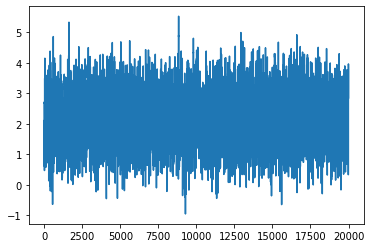

In [1]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#from scipy.stats import wishart, multivariate_normal, bernoulli, multinomial
#from scipy.sparse import csr_matrix
#from sklearn.model_selection import train_test_split
import os, pickle
import numpy as np
import math
#from numpy import log, sum, exp, prod
from numpy.random import beta, binomial, normal, dirichlet, uniform, gamma, seed, multinomial, gumbel, rand
from imp import reload
from copy import deepcopy
from math import cos, pi
#import seaborn as sns
import pandas as pd
import time
#from scipy.spatial.distance import euclidean
import itertools
from itertools import chain, combinations


def cycle(N, nof_cycles = 1):
  return np.cos(2*pi*np.arange(0,N)*nof_cycles/N)

def simAR1(N, phi, sigma, const = 0, burn=100):
  y = np.zeros((N+burn))
  for t in range(N+burn-1):
    y[t+1] = const + phi*y[t] + normal(scale = sigma, size=1)     
  return y[burn:]

#np.random.seed(0)   # set seed

N = 2*10**4
omega = 1
phi_true = 0.77
sigma_true = 0.5

y1 = simAR1(N, phi = phi_true, sigma = sigma_true, const = 0.5)
#y1 = omega*cycle(N, nof_cycles = 2) + simAR1(N, phi = 0.7, sigma = 0.6)
#y2 = omega*cycle(N, nof_cycles = 2) + simAR1(N, phi = 0.7, sigma = 0.6)
#y3 = omega*cycle(N , nof_cycles = 2) + simAR1(N , phi = 0.5, sigma = 1.4)
#y4 = omega*cycle(N, nof_cycles = 2) 

# Plot trajectories:
#---------------------
plt.figure()
pd.Series(y1).plot() 
plt.show()

In [ ]:
def embed(data : pd.DataFrame, lags : int, dropnan=True):
  df = pd.DataFrame(data) 
  colnames = data.columns
  cols, names = list(), list()
  k = data.shape[1]
  for j in range(0,k):
    ts = df.iloc[:,j]
    for i in range(0,lags+1):
      cols.append(ts.shift(i))                                  # lag series/shift series up
      names.append(str(colnames[j]) + '_lag' + str(i))             # make names
  agg = pd.concat(cols, axis=1)                          # concatenate the matrix list elements to dataframe -> cbind
  agg.columns = names  
  if dropnan:
    agg.dropna(inplace=True)              	# drop rows with NaN values
  return(agg)  

In [ ]:
# Split the targets into training/testing sets
#-----------------------------------------------
p_test = 0.3
hold = math.floor(N*p_test)
y_train, y_test = y1[:-hold], y1[-hold:]       # last 10 rows
y_train.shape

(140000,)

In [ ]:
df_train = embed(pd.DataFrame(y_train, columns=['y']), lags = 1)
df_train.tail()

,y_lag0,y_lag1
139995,1.782449,1.922644
139996,2.385873,1.782449
139997,2.681713,2.385873
139998,2.243259,2.681713
139999,2.615544,2.243259


In [ ]:
df_test = embed(pd.DataFrame(y_test, columns=['y']), lags = 1)
df_test.head()

,y_lag0,y_lag1
1,3.206748,2.843922
2,2.666579,3.206748
3,2.706917,2.666579
4,2.690943,2.706917
5,2.572235,2.690943


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor

In [ ]:
df_train.shape
df_test.shape

(59990, 11)

In [ ]:
y_train = df_train.iloc[:,0]
X_train = df_train[df_train.columns.drop('y_lag0')]

y_test = df_test.iloc[:,0]
X_test = df_test[df_test.columns.drop('y_lag0')]

In [ ]:
scaler = StandardScaler().fit(X_train)      # make a scaler
scaler

scaler.mean_
scaler.scale_

# Do it for the training set:
Xtrain = scaler.transform(X_train)
# apply it to the test set
Xtest = scaler.transform(X_test)


No handles with labels found to put in legend.


beta_hat: [ 7.72896225e-01 -5.77290199e-03  6.10843298e-04 -7.27839198e-04
  2.44616823e-03 -6.26974497e-03  6.14265914e-03 -1.83497401e-04
 -2.46753170e-03 -7.35003026e-04]
drift_hat: 0.5096122439415622
beta_true: 0.77
R2 train: 0.5906716119977016
0.4998542744265195
R2 test: 0.5987098909472677


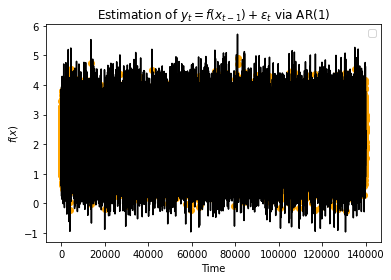

In [ ]:
lr = LinearRegression(normalize = False, fit_intercept=True)

linreg_fit = lr.fit(X_train, y_train)

yhat = linreg_fit.predict(X_train)

# The coefficients
print('beta_hat:', linreg_fit.coef_)
print('drift_hat:', linreg_fit.intercept_)
print('beta_true:', phi_true)

LM_rmse = np.sqrt(mean_squared_error(y_train, yhat))         # RMSE

print('R2 train:', r2_score(y_train, yhat))
print(LM_rmse)

yhat_test = linreg_fit.predict(X_test)
print('R2 test:', r2_score(y_test, yhat_test))

yhat_lm = yhat

# Plot the results:
#------------------------------------
x = np.arange(1,len(y_train)+1); 
fig = plt.figure()
ax = fig.add_subplot(111)
lines = ax.plot(x, y_train,color="black")
ax.scatter(x, yhat_lm, color="orange")   
ax.set(title = r'Estimation of $y_{t} = f(x_{t-1}) + \epsilon_{t}$ via AR(1)', xlabel = "Time", ylabel="$f(x)$")
ax.legend(loc = "best")


No handles with labels found to put in legend.


0.3884587939406829
R2 train: 0.752784919666635
R2 test: 0.5987098909472677


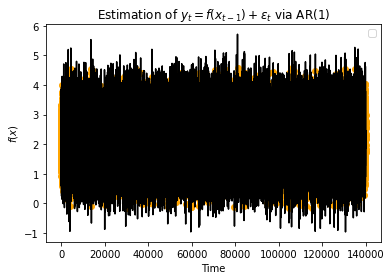

In [ ]:
RF = RandomForestRegressor(oob_score = True, n_estimators = 100, min_samples_leaf=10)

RF_fit = RF.fit(X_train, y_train)
yhat = RF_fit.predict(X_train)

RF_rmse = np.sqrt(mean_squared_error(y_train, yhat))         # RMSE

print(RF_rmse)
print('R2 train:', r2_score(y_train, yhat))

yhat_test = linreg_fit.predict(X_test)
print('R2 test:', r2_score(y_test, yhat_test))

yhat_RF = yhat

# Plot the results:
#------------------------------------
x = np.arange(1,len(y_train)+1); 
fig = plt.figure()
ax = fig.add_subplot(111)
lines = ax.plot(x, y_train,color="black")
ax.scatter(x, yhat_RF, color="orange")   
ax.set(title = r'Estimation of $y_{t} = f(x_{t-1}) + \epsilon_{t}$ via AR(1)', xlabel = "Time", ylabel="$f(x)$")
ax.legend(loc = "best")


[0.12404469 0.13973038 0.14397152 0.13702959 0.13220311 0.13440072
 0.14390515 0.12297429 0.13473153 0.16480832]
1.493348949721883e-05
R2 train: 0.9999999996346512
R2 test: 0.16135838229450872


No handles with labels found to put in legend.


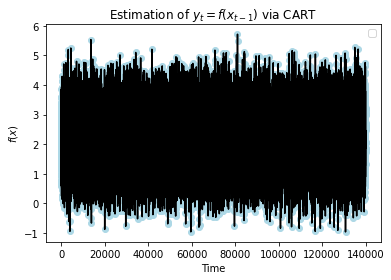

In [ ]:
tree_reg = DecisionTreeRegressor()
tree_fit = tree_reg.fit(X_train, y_train)

scores = cross_val_score(tree_reg, X_train, y_train, cv=10)

print(scores)

yhat = tree_fit.predict(X_train)
yhat_test = tree_fit.predict(X_test)

tree_rmse = np.sqrt(mean_squared_error(y_train, yhat))         # RMSE

print(tree_rmse)
print('R2 train:', r2_score(y_train, yhat))
print('R2 test:', r2_score(y_test, yhat_test))

yhat_cart = yhat

# Plot the results:
#------------------------------------
x = np.arange(1,len(y_train)+1); 
fig = plt.figure()
ax = fig.add_subplot(111)
lines = ax.plot(x,y_train,color="black")
#plt.title(r'Function estimation $f(x)$', fontsize = 20)
ax.scatter(x,yhat_cart, color="lightblue")
ax.set(title = r'Estimation of $y_{t} = f(x_{t-1})$ via CART', xlabel = "Time", ylabel="$f(x)$")
ax.legend(loc = "best")


# Gibbs samplig - Changepoint analysis:

In [ ]:
N1 = 1*10**3
N2 = 1*10**3
N3 = 1*10**3

omega = 1
phi_true = 0.77
sigma_true = 0.5

#cps = [N1+1]

cps = [N1+1, N1+N2+1]

y1 = simAR1(N1, phi = phi_true, sigma = sigma_true, const = 0)    # Regime 1
y2 = simAR1(N2, phi = .4*phi_true, sigma = sigma_true, const = 1.5)    # Regime 2
y3 = simAR1(N3, phi = phi_true, sigma = 0.9*sigma_true, const = 0.2)    # Regime 2

y = np.concatenate((y1,y2, y3),axis=0)              # data with level shift
cps

[1001, 2001]

No handles with labels found to put in legend.


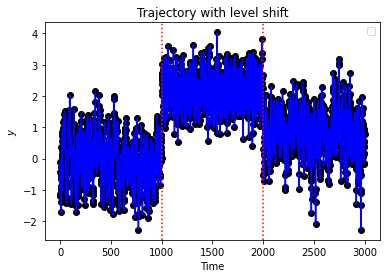

In [ ]:
# Plot the results:
#------------------------------------
x = np.arange(1,len(y)+1); 
fig = plt.figure()
ax = fig.add_subplot(111)
lines = ax.plot(x,y,color="blue")
ax.scatter(x,y, color="black")
for cp in cps:
     ax.axvline(cp, c='red', ls='dotted')
ax.set(title = r'Trajectory with level shift', xlabel = "Time", ylabel="$y$")
ax.legend(loc = "best")

In [ ]:
from scipy.stats import norm
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#fig, ax = plt.subplots(1, 1)
#x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)
#ax.plot(x, norm.pdf(x), 'r-', lw=2, alpha=0.6, label='norm pdf')
#plt.show()

No handles with labels found to put in legend.


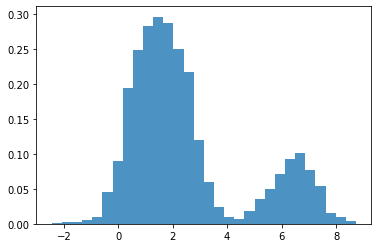

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(y, bins=30, density=True, histtype='stepfilled', alpha=0.8)
ax.legend(loc='best', frameon=False)
plt.show()

In [ ]:
lhs = deepcopy(y)

In [ ]:
X_lagged = embed(pd.DataFrame(y, columns=['y']), lags = 1)
X_til = X_lagged[['y_lag1']]
X_til['const'] = 1.
X_til = X_til.to_numpy()
lhs = X_lagged[['y_lag0']].to_numpy()
#X_til.tail()
X_til
lhs

array([[3.09812208],
       [2.22194947],
       [2.69016366],
       ...,
       [5.48608109],
       [6.18353525],
       [6.9171223 ]])

In [ ]:
n = len(y)
p = 1
tau = 3
n_new = n - p
k = [1, np.floor((n - 1) * 0.5), n_new]     # single break only!
k

[1, 999.0, 1999]

In [ ]:
kBeg = k[0] + tau + p
kEnd = k[2] - 1
prob = np.zeros(kEnd - kBeg + 1)
prob

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
j = kBeg

In [ ]:
beta = np.linalg.pinv(X_til.T @ X_til) @ X_til.T @ lhs
beta

array([[0.97188358],
       [0.12695625]])

In [ ]:
lhs[kBeg:kEnd]

array([[2.05449115],
       [1.33370501],
       [1.25069753],
       ...,
       [5.79107615],
       [5.48608109],
       [6.18353525]])

In [ ]:
err = lhs[kBeg:kEnd] - X_til[kBeg:kEnd, :] @ beta

In [ ]:
X_til

array([[2.79265801, 1.        ],
       [3.09812208, 1.        ],
       [2.22194947, 1.        ],
       ...,
       [5.79107615, 1.        ],
       [5.48608109, 1.        ],
       [6.18353525, 1.        ]])

In [ ]:
X_til[kBeg:kEnd, :]

array([[1.67084654, 1.        ],
       [2.05449115, 1.        ],
       [1.33370501, 1.        ],
       ...,
       [6.46292458, 1.        ],
       [5.79107615, 1.        ],
       [5.48608109, 1.        ]])

In [38]:
from sklearn.base import BaseEstimator, OutlierMixin
from   scipy.stats import norm
from   scipy.special import logsumexp
from tqdm import tqdm

class BayesOCPD(BaseEstimator, OutlierMixin):
    """
    Bayesian online change point detection, see Adams & MacKay 2007.
    """
    def __init__(self, model, hazard, mini_run_length : int = 10, verbose : bool = True):
        self.verbose = verbose
        self.model = model
        self.hazard = hazard
        self.mini_run_length = mini_run_length
        if self.verbose : print("*** Bayesian online change point detection ***")

    def fit(self, X, y=None):    
        """
        Return run length posterior using Algorithm 1
        """
        data = deepcopy(X)
        # 1. Initialize
        T           = len(data)
        log_R       = -np.inf * np.ones((T+1, T+1))    # log posterior values of run length at time t
        log_R[0, 0] = 0              # log 0 == 1
        pmean       = np.empty(T)    # Model's predictive mean.
        pvar        = np.empty(T)    # Model's predictive variance. 
        log_message = np.array([0])  # log 0 == 1
        log_H       = np.log(self.hazard)
        log_1mH     = np.log(1 - self.hazard)
        cps_MAP     = np.empty(T) 

        for t in tqdm(range(1, T+1)):       # forward filtering 
            # 2. Observe new datum.
            x = data[t-1]

            # Make model predictions. ('step 9'). Calculate first two moments
            pmean[t-1] = np.sum(np.exp(log_R[t-1, :t]) * self.model.mean_params[:t])   # up to t-1
            pvar[t-1]  = np.sum(np.exp(log_R[t-1, :t]) * self.model.var_params[:t])
            
            # 3. Evaluate predictive posterior probabilities.
            log_pis = model.log_pred_prob(t, x)

            # 4. Calculate growth probabilities ('No break')
            log_growth_probs = log_pis + log_message + log_1mH

            # 5. Calculate changepoint/Break probabilities.
            log_cp_prob = logsumexp(log_pis + log_message + log_H)

            # 6. Calculate evidence
            new_log_joint = np.append(log_cp_prob, log_growth_probs)    # append: pr(r_t == 0), pr(r_t > 0)'s

            # 7. Determine run length posterior mass distribution.
            log_R[t, :t+1]  = new_log_joint
            log_R[t, :t+1] -= logsumexp(new_log_joint)            # normalize entries by dividing by column sum

            # 8. Update sufficient statistics.
            # here: mean_params & prec_params
            model.update_params(t, x)

            # Pass message.
            log_message = new_log_joint

            # Select break points, via MAP state estimate        
            cps_MAP[t-1] = np.argmax(log_R[t-1,:t])
        
        self.pmean = pmean
        self.pvar = pvar
        self.R = np.exp(log_R)
        self.log_R = log_R
        self.cps_MAP = cps_MAP
        return self
    
    # Future: change this to be able run for online oob samples
    def predict(self, X):
        lab = np.ones(len(X))
        lab[self.score(X)] = -1
        return lab

    def score(self, X):
        #return np.amax(self.R, 1)    
        cps_est = np.where((self.cps_MAP[1:] - self.cps_MAP[:-1]) < -self.mini_run_length)[0]    # MAP estimates of change points
        return cps_est


# Bayesian Online Changepoint detection

In [27]:
import matplotlib.pyplot as plt
from   matplotlib.colors import LogNorm
import numpy as np
from   scipy.stats import norm
from   scipy.special import logsumexp
from tqdm import tqdm

# https://github.com/gwgundersen/bocd

def bocd(data, model, hazard, mini_run_length : int = 10):   # minimum run length in time units until break
    """
    Return run length posterior using Algorithm 1 in Adams & MacKay 2007.
    """
    # 1. Initialize lower triangular matrix representing the posterior as
    #    function of time. Model parameters are initialized in the model class.
    #    
    #    When we exponentiate R at the end, exp(-inf) --> 0, which is nice for
    #    visualization.
    #
    T           = len(data)
    log_R       = -np.inf * np.ones((T+1, T+1))    # log posterior values of run length at time t
    log_R[0, 0] = 0              # log 0 == 1
    pmean       = np.empty(T)    # Model's predictive mean.
    pvar        = np.empty(T)    # Model's predictive variance. 
    log_message = np.array([0])  # log 0 == 1
    log_H       = np.log(hazard)
    log_1mH     = np.log(1 - hazard)
    cps_MAP     = np.empty(T) 

    for t in tqdm(range(1, T+1)):       # forward filtering in HMM (see https://en.wikipedia.org/wiki/Forward_algorithm#Algorithm)
        # 2. Observe new datum.
        x = data[t-1]

        # Make model predictions. ('step 9'). Calculate first two moments
        pmean[t-1] = np.sum(np.exp(log_R[t-1, :t]) * model.mean_params[:t])   # up to t-1
        pvar[t-1]  = np.sum(np.exp(log_R[t-1, :t]) * model.var_params[:t])
        
        # 3. Evaluate predictive posterior probabilities.
        log_pis = model.log_pred_prob(t, x)

        # 4. Calculate growth probabilities ('No break')
        log_growth_probs = log_pis + log_message + log_1mH

        # 5. Calculate changepoint/Break probabilities.
        log_cp_prob = logsumexp(log_pis + log_message + log_H)

        # 6. Calculate evidence
        new_log_joint = np.append(log_cp_prob, log_growth_probs)    # append: pr(r_t == 0), pr(r_t > 0)'s

        # 7. Determine run length posterior mass distribution.
        log_R[t, :t+1]  = new_log_joint
        log_R[t, :t+1] -= logsumexp(new_log_joint)            # normalize entries by dividing by column sum

        # 8. Update sufficient statistics.
        # here: mean_params & prec_params
        model.update_params(t, x)

        # Pass message.
        log_message = new_log_joint
        
        # Select break points, via MAP state estimate        
        cps_MAP[t-1] = np.argmax(log_R[t-1,:t])

    R = np.exp(log_R)
           
    cps_est = np.where((cps_MAP[1:] - cps_MAP[:-1]) < -mini_run_length)[0]    # MAP estimates of change points

    return R, pmean, pvar, cps_MAP, cps_est

# -----------------------------------------------------------------------------

class GaussianUnknownMean:
    
    def __init__(self, mean0, var0, varx):
        """
        Initialize model.
        
        meanx is unknown; varx is known
        p(meanx) = N(mean0, var0)
        p(x) = N(meanx, varx)
        """
        self.mean0 = mean0               # mu_0
        self.var0  = var0                # sigma2_0
        self.varx  = varx                # sigma2
        self.mean_params = np.array([mean0])      # mu_n   ; initialize posterior param. with prior hyperparameters -> used for posterior predictive distr. \pi_t (step 3)
        self.prec_params = np.array([1/var0])     # lambda_n
    
    def log_pred_prob(self, t, x):
        """
        Compute predictive probabilities \pi, i.e. the posterior predictive
        for each run length hypothesis.
        """
        # Posterior predictive: see eq. 40 in (Murphy 2007).
        post_means = self.mean_params[:t]
        post_stds  = np.sqrt(self.var_params[:t])        #  use current variance parameter attribute
        return norm(post_means, post_stds).logpdf(x)
    
    def update_params(self, t, x):
        """
        Upon observing a new datum x at time t, update all run length 
        hypotheses.
        """
        # See eq. 19 in (Murphy 2007).
        new_prec_params  = self.prec_params + (1/self.varx)         # lambda_n (27)
        self.prec_params = np.append([1/self.var0], new_prec_params)   # recursively update precision parameters

        # See eq. 24 in (Murphy 2007).
        new_mean_params  = (self.mean_params * self.prec_params[:-1] + \
                            (x / self.varx)) / new_prec_params
        self.mean_params = np.append([self.mean0], new_mean_params)    # recursively update mean parameters

    @property
    def var_params(self):
        """Helper function for computing the posterior variance sigma2_n
        """
        return 1./self.prec_params + self.varx  # can be accessed as attribute var_params, rather than a function call var_params()

# -----------------------------------------------------------------------------

def generate_data(varx, mean0, var0, T, cp_prob):
    """Generate partitioned data of T observations according to constant
    changepoint probability `cp_prob` with hyperpriors `mean0` and `prec0`.
    """
    data  = []
    cps   = []
    meanx = mean0
    for t in range(0, T):
        if np.random.random() < cp_prob:
            meanx = np.random.normal(mean0, var0)    # draw a new mean parameter with prob. cp_prob
            cps.append(t)
        data.append(np.random.normal(meanx, varx))
    return data, cps


# -----------------------------------------------------------------------------

def plot_posterior(T, data, cps, cps_estimated, R, pmean, pvar, plot_est_cps = True):
    fig, axes = plt.subplots(2, 1, figsize=(20,10))

    ax1, ax2 = axes
    # Plot raw data
    ax1.scatter(range(0, T), data)
    ax1.plot(range(0, T), data)
    ax1.set_xlim([0, T])
    ax1.margins(0)
    
    # Plot predictions mean and confidence bounds based on Gaussian posterior predictive distr.
    ax1.plot(range(0, T), pmean, c='k')
    _2std = 2 * np.sqrt(pvar)
    ax1.plot(range(0, T), pmean - _2std, c='k', ls='--')
    ax1.plot(range(0, T), pmean + _2std, c='k', ls='--')

    ax2.imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
               norm=LogNorm(vmin=0.0001, vmax=1))
    ax2.set_xlim([0, T])
    ax2.margins(0)

    for cp in cps:
        ax1.axvline(cp, c='red', ls='--')
        ax2.axvline(cp, c='red', ls='--')

    if plot_est_cps: 
      for cp in cps_estimated:
          ax1.axvline(cp, c='green', ls='dotted')
          ax2.axvline(cp, c='green', ls='dotted')

    plt.tight_layout()
    plt.show()
    

In [28]:
T      = 1000   # Number of observations.
hazard = .01  # Constant prior on changepoint probability.
mean0  = 0      # The prior mean on the mean parameter.
var0   = 2      # The prior variance for mean parameter.
varx   = 1      # The known variance of the data.

data, cps      = generate_data(varx, mean0, var0, T, hazard)
model          = GaussianUnknownMean(mean0, var0, varx)

R, pmean, pvar, cps_MAP, cps_est = bocd(data, model, hazard, mini_run_length = T*.05)    

100%|██████████| 1000/1000 [00:01<00:00, 795.96it/s]


In [39]:
bc = BayesOCPD(model, hazard)

*** Bayesian online change point detection ***


In [42]:
cp_hat = bc.fit_predict(data)

100%|██████████| 1000/1000 [00:01<00:00, 794.41it/s]


In [41]:
R, pmean, pvar, cps_MAP = bc.R, bc.pmean, bc.pvar, bc.cps_MAP

In [ ]:
pd.set_option('display.max_rows', 10**4)

In [ ]:
dd = pd.DataFrame((cps_MAP[1:] - cps_MAP[:-1]), columns=['runs'])
dd['cps_t'] = cps_MAP[1:]
dd['cps_tm1']= cps_MAP[:-1]
dd.head()

,runs,cps_t,cps_tm1
0,1.0,1.0,0.0
1,1.0,2.0,1.0
2,1.0,3.0,2.0
3,1.0,4.0,3.0
4,1.0,5.0,4.0


In [ ]:
cps

[26, 66, 325, 411, 714, 764, 766, 852, 905, 914]

In [ ]:
#cps_est = np.where((cps_MAP[1:] - cps_MAP[:-1]) < -10)[0]    # MAP estimates of change points
cps_est

array([189, 326, 411, 652, 718, 852, 917])

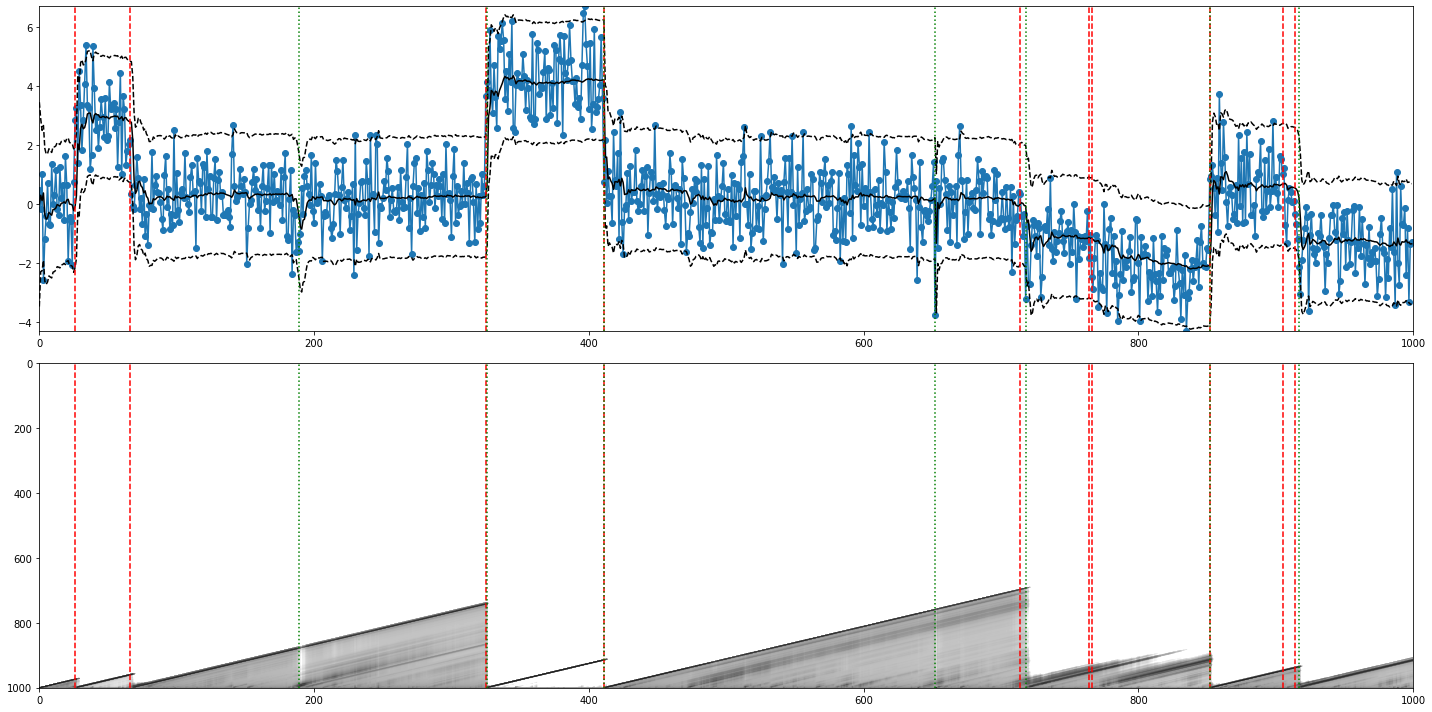

In [ ]:
plot_posterior(T, data, cps, cps_est, R, pmean, pvar, True)

Use own data:

In [ ]:
data = deepcopy(y)
hazard = .01
T = len(data)
print(T)

NameError: ignored

In [ ]:
model          = GaussianUnknownMean(mean0, var0, varx)

R, pmean, pvar, cps_MAP, cps_est = bocd(data, model, hazard, T*.1)    

100%|██████████| 3000/3000 [00:04<00:00, 715.26it/s]


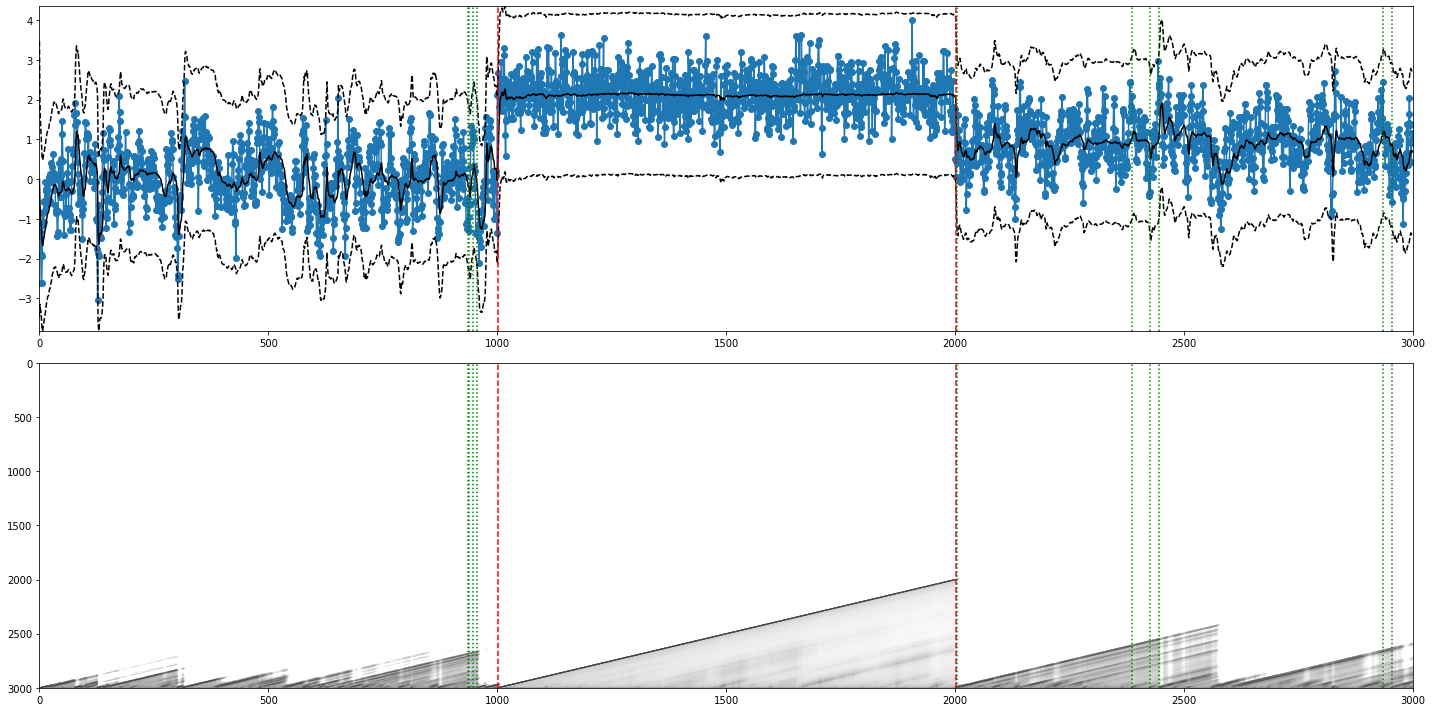

In [ ]:
plot_posterior(T, data, cps, cps_est, R, pmean, pvar, True)

In [ ]:
cps

[1001, 2001]

In [ ]:
cps_est

array([ 936,  938,  947,  956, 2003, 2387, 2426, 2445, 2934, 2955])

In [ ]:
R.shape

(21, 21)

In [ ]:
for i in range(R.shape[1]):
   print('t = {} {}\n'.format(i,R[i,:]))

t = 0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

t = 1 [0.01 0.99 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.  ]

t = 2 [0.01       0.00751107 0.98248893 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]

t = 3 [0.01       0.00680282 0.0067973  0.97639988 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]

t = 4 [0.01       0.00678666 0.00609694 0.006417   0.9706994  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]

t = 5 [0.01       0.00651595 0.00557727 0.00555195 0.00624962 0.9661052
 0.         0.         0.         0.         0.         0.
 0.         0.         0.  

In [ ]:
#fig, axes = plt.subplots(1, 1, figsize=(20,10))
#R_ = np.rot90(R)
#axes.scatter(range(0, T), R[1002,:T])

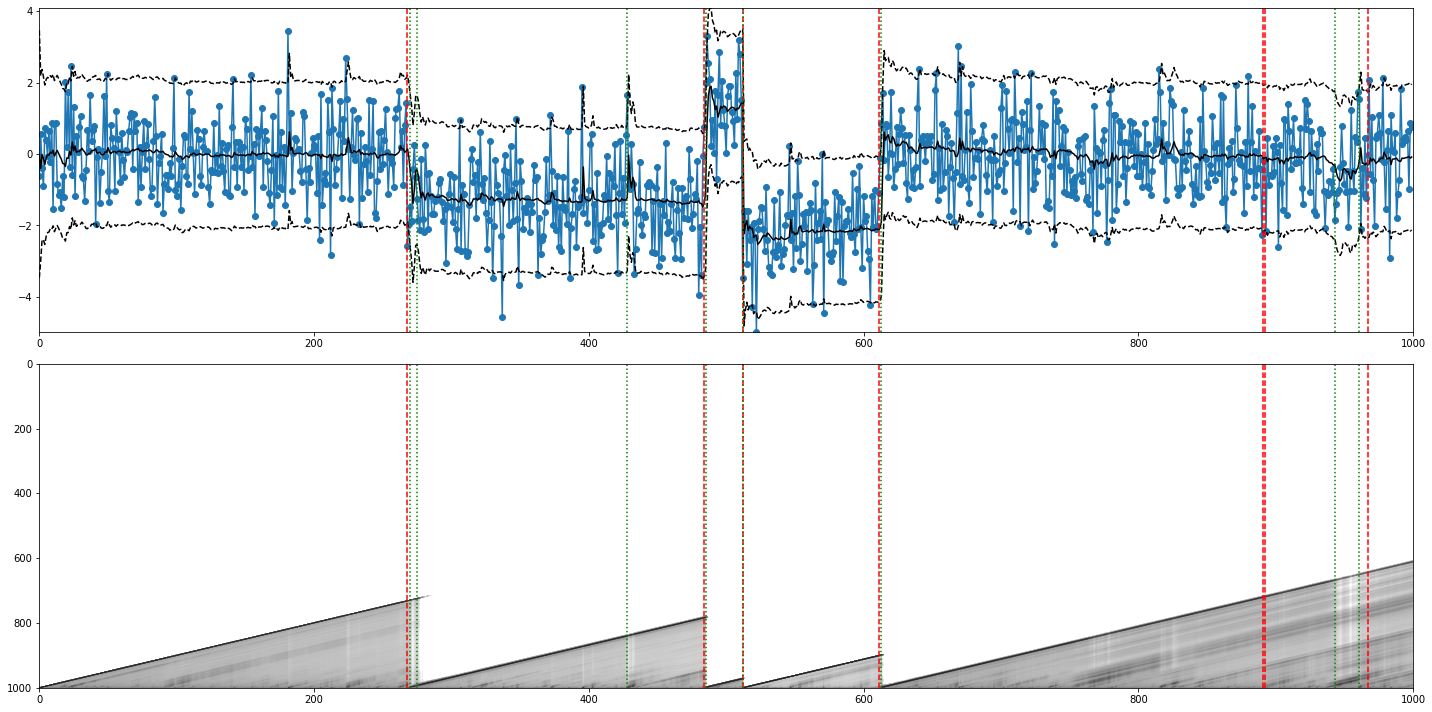

In [ ]:
# fig, axes = plt.subplots(2, 1, figsize=(20,10))

# ax1, ax2 = axes

# ax1.scatter(range(0, T), data)
# ax1.plot(range(0, T), data)
# ax1.set_xlim([0, T])
# ax1.margins(0)

# # Plot predictions mean and confidence bounds based on Gaussian posterior predictive distr.
# ax1.plot(range(0, T), pmean, c='k')
# _2std = 2 * np.sqrt(pvar)
# ax1.plot(range(0, T), pmean - _2std, c='k', ls='--')
# ax1.plot(range(0, T), pmean + _2std, c='k', ls='--')

# ax2.imshow(np.rot90(R), aspect='auto', cmap='gray_r', 
#             norm=LogNorm(vmin=0.0001, vmax=1))
# ax2.set_xlim([0, T])
# ax2.margins(0)

# for cp in cps:
#     ax1.axvline(cp, c='red', ls='--')
#     ax2.axvline(cp, c='red', ls='--')

# cps_estimated = np.where( (cps_MAP[1:] - cps_MAP[:-1]) < 0 )[0] 
# for cp in cps_estimated:
#     ax1.axvline(cp, c='green', ls='dotted')
#     ax2.axvline(cp, c='green', ls='dotted')

# plt.tight_layout()
# plt.show()

In [ ]:
#https://maxhalford.github.io/blog/bayesian-linear-regression/

import numpy as np
from scipy import stats

class BayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha                    # prior hyperparameter
        self.beta = beta                       # prior hyperparameter
        self.mean = np.zeros(n_features)    # instantiate for sequential update
        self.cov_inv = np.identity(n_features) / alpha     # 2nd moment of isotropic Gaussian prior of weights w (see Bishop)

    def learn(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)
        #cov_inv = self.cov_inv + self.beta * (x.T @ x)

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)
        
        # Recursive updates:
        self.cov_inv = cov_inv
        self.mean = mean
        return self

    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)    # pdf

    @property
    def post_distr_weights(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=self.mean, cov=cov)   # pdf


In [ ]:
from sklearn import datasets
from sklearn import metrics

X, y = datasets.load_boston(return_X_y=True)

In [ ]:
# AR(1) model:
X_lagged = embed(pd.DataFrame(y, columns=['y']), lags = 1)
X_til = X_lagged[['y_lag1']]
X_til['const'] = 1.
X = X_til.to_numpy()
y = X_lagged[['y_lag0']].to_numpy()

In [ ]:
# Call:
#model = BayesLinReg(n_features=X.shape[1], alpha=.3, beta=1)
# Offline learning/ full batch
#model.learn(X, y)

#y_pred = model.predict(X).mean()

#print(metrics.mean_absolute_error(y, y_pred))


In [ ]:
# Call:
model = BayesLinReg(n_features=X.shape[1], alpha=.3, beta=1)

# Online learning - single batch
# Sequential updating / learning of posterior parameters
y_pred = np.empty(len(y))
for i, (xi, yi) in enumerate(zip(X, y)):
    y_pred[i] = model.predict(xi).mean()
    model.learn(xi, yi)

print(metrics.mean_absolute_error(y, y_pred))


3.784125061857545


In [ ]:
y_pred

array([ 0.        , 22.52721042, 21.49223736, 48.12501415, 28.31169703,
       30.27159634, 28.08859968,  7.94565966, 22.18887728, 24.18579665,
       21.27931025, 22.13183385, 29.16885916, 23.83285167, 16.61871374,
       21.16190354, 21.43287054, 17.66300806,  7.50180577, 19.06749996,
       14.10297982, 17.59402393, 17.73534153, 15.50857362, 17.16491215,
       13.55134485, 17.0157424 , 14.60755594, 18.96230094, 19.50809892,
       13.86942144, 16.17855708, 10.09828273, 13.77839892, 11.44073155,
       19.93125622, 19.21958051, 22.80659819, 23.42225998, 70.3128542 ,
       33.38247417, 34.50113436, 28.47193393, 27.47555594, 24.29828196,
       21.9249766 , 20.79144403, 18.81855749, 12.24197504, 19.44899964,
       24.70419365, 24.9485254 , 28.69048887, 25.5676478 , 26.89360868,
       35.14365748, 29.15079338, 31.76929289, 27.00300681, 23.50434522,
       19.87662492, 19.13366327, 23.72824884, 25.47127161, 29.24308283,
       27.2165532 , 22.48806337, 21.93134128, 18.93849527, 21.14

ValueError: ignored

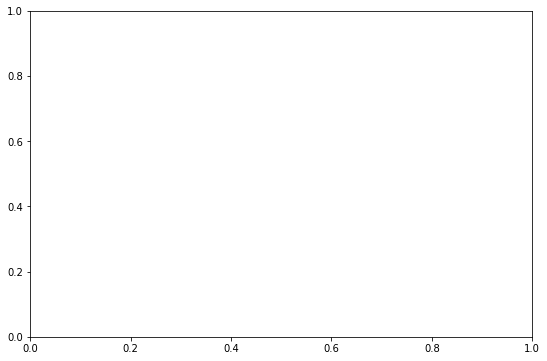

In [ ]:
np.random.seed(42)

model = BayesLinReg(n_features=2, alpha=1, beta=25)
pct_in_ci = 0
pct_in_ci_hist = []
n = 5000

for i, (xi, yi) in enumerate(sample(n)):

    ci = model.predict(xi).interval(.95)
    in_ci = ci[0] < yi < ci[1]
    pct_in_ci += (in_ci - pct_in_ci) / (i + 1)  # online update of an average
    pct_in_ci_hist.append(pct_in_ci)

    model.learn(xi, yi)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(range(n), pct_in_ci_hist)
ax.axhline(y=.95, color='red', linestyle='--')
ax.set_title('Quality of the prediction interval along time')
ax.set_xlabel('# of observed samples')
ax.set_ylabel('% of predictions in 95% prediction interval')
ax.set_ylim(.9, 1)
ax.grid()


In [ ]:
def sherman_morrison(A_inv, u, v):
    num = A_inv @ np.outer(u, v) @ A_inv
    den = 1 + v @ A_inv @ u
    return A_inv - num / den


class SimpleBayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.A_inv = np.linalg.inv(alpha * np.identity(n_features))
        self.cov = self.A_inv

    def learn(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.54)
        self.cov = sherman_morrison(A_inv=self.A_inv, u=self.beta * x, v=x)

        # Update the mean vector (Bishop eq. 3.53)
        self.mean = self.beta * self.cov @ x * y

        return self

    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        y_pred_var = 1 / self.beta + x @ self.cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)


In [ ]:
X, y = datasets.load_boston(return_X_y=True)

model = SimpleBayesLinReg(n_features=X.shape[1], alpha=.3, beta=1)

y_pred = np.empty(len(y))

for i, (xi, yi) in enumerate(zip(X, y)):
    y_pred[i] = model.predict(xi).mean()
    model.learn(xi, yi)

print(metrics.mean_absolute_error(y, y_pred))


4.609682709020295
